# Exemplo de Simulação com o Pacote U-Classifier

Este notebook demonstra como usar as funções do pacote `uclassifier` para replicar as simulações descritas no artigo de Ahmad & Pavlenko (2018).

**Objetivo:**
1.  Gerar gráficos de taxa de erro (`e(1|0)` e `e(0|1)`) em função da dimensionalidade `p`.
2.  Gerar QQ-plots para analisar a normalidade do classificador `A(x)`.

In [1]:
# Importa as funções necessárias do pacote e de outras bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from u_classifier_hd.aux import (
    create_ar1_covariance,
    create_unstructured_covariance,
    generate_mean_vectors,
    calculate_theoretical_errors,
    run_simulation_iteration,
    plot_results,
    plot_qq,
    generate_data
)
from u_classifier_hd.core import u_classifier_multisample

## Seção 1: Simulação das Taxas de Erro

--- Iniciando Simulação: n1=5, n2=7 | Covariâncias: AR-AR ---
  Avaliando para Estimado: NORMAL...
    p = 10   | e(1|0)=0.2050, e(0|1)=0.2512
    p = 20   | e(1|0)=0.1448, e(0|1)=0.1944
    p = 50   | e(1|0)=0.0478, e(0|1)=0.1218
    p = 100  | e(1|0)=0.0086, e(0|1)=0.0591
    p = 300  | e(1|0)=0.0000, e(0|1)=0.0037
    p = 500  | e(1|0)=0.0000, e(0|1)=0.0004
  Avaliando para Estimado: T-STUDENT...
    p = 10   | e(1|0)=0.2468, e(0|1)=0.2742
    p = 20   | e(1|0)=0.1544, e(0|1)=0.2126
    p = 50   | e(1|0)=0.0616, e(0|1)=0.1497
    p = 100  | e(1|0)=0.0257, e(0|1)=0.0756
    p = 300  | e(1|0)=0.0013, e(0|1)=0.0120
    p = 500  | e(1|0)=0.0001, e(0|1)=0.0036


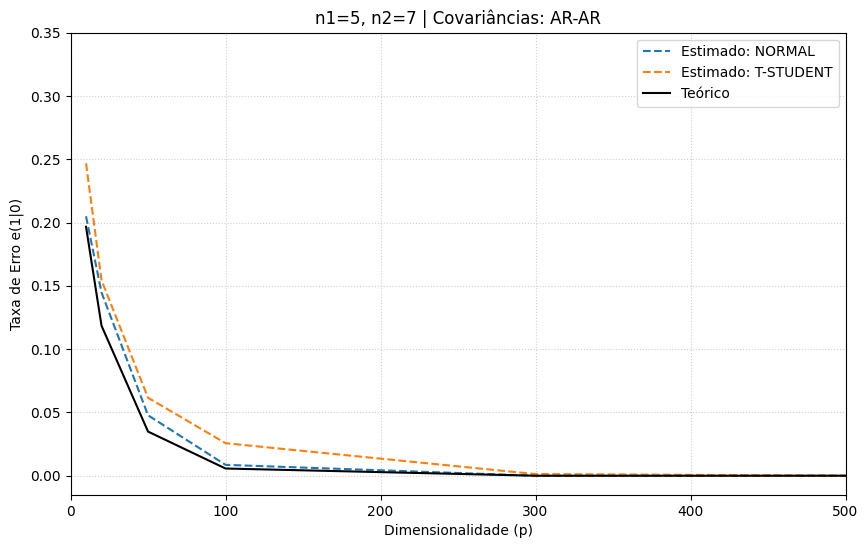

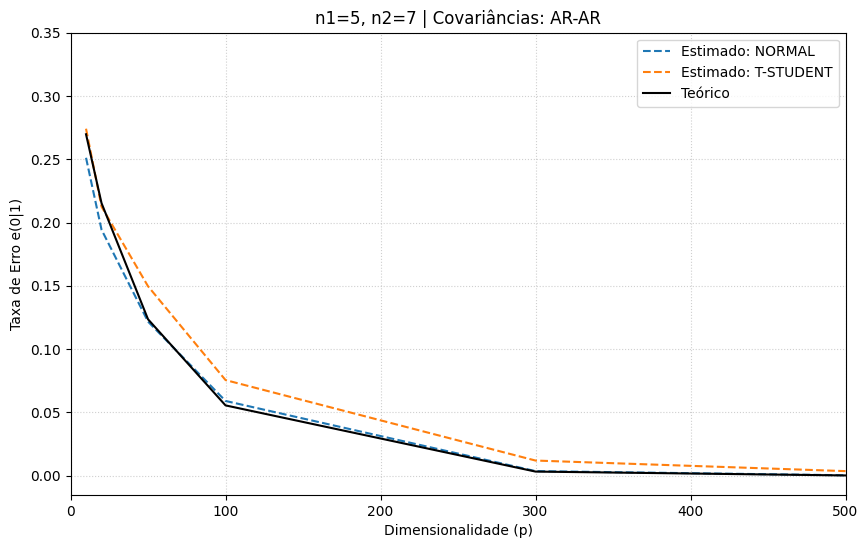

--- Iniciando Simulação: n1=10, n2=12 | Covariâncias: AR-AR ---
  Avaliando para Estimado: NORMAL...
    p = 10   | e(1|0)=0.1663, e(0|1)=0.2688
    p = 20   | e(1|0)=0.1072, e(0|1)=0.2054
    p = 50   | e(1|0)=0.0292, e(0|1)=0.1156
    p = 100  | e(1|0)=0.0038, e(0|1)=0.0524
    p = 300  | e(1|0)=0.0000, e(0|1)=0.0023
    p = 500  | e(1|0)=0.0000, e(0|1)=0.0002
  Avaliando para Estimado: T-STUDENT...
    p = 10   | e(1|0)=0.1825, e(0|1)=0.2733
    p = 20   | e(1|0)=0.1420, e(0|1)=0.2084
    p = 50   | e(1|0)=0.0446, e(0|1)=0.1352
    p = 100  | e(1|0)=0.0130, e(0|1)=0.0688
    p = 300  | e(1|0)=0.0004, e(0|1)=0.0092
    p = 500  | e(1|0)=0.0000, e(0|1)=0.0025


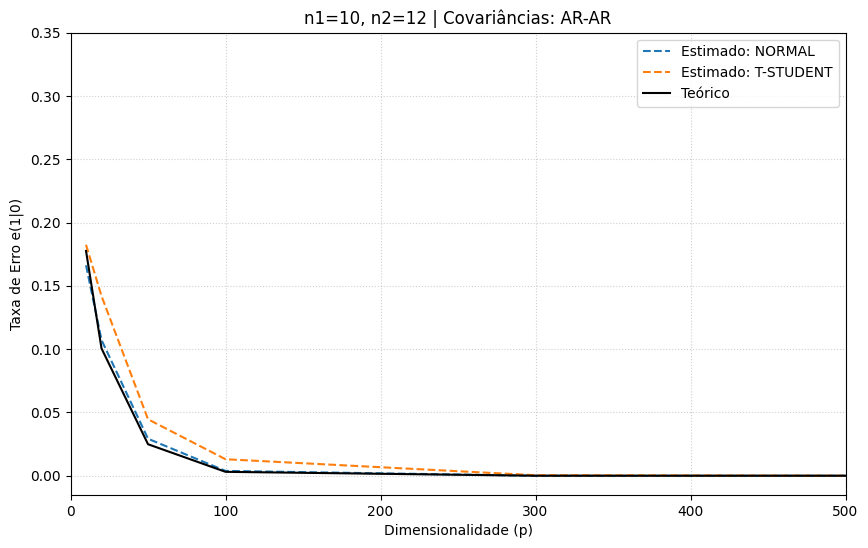

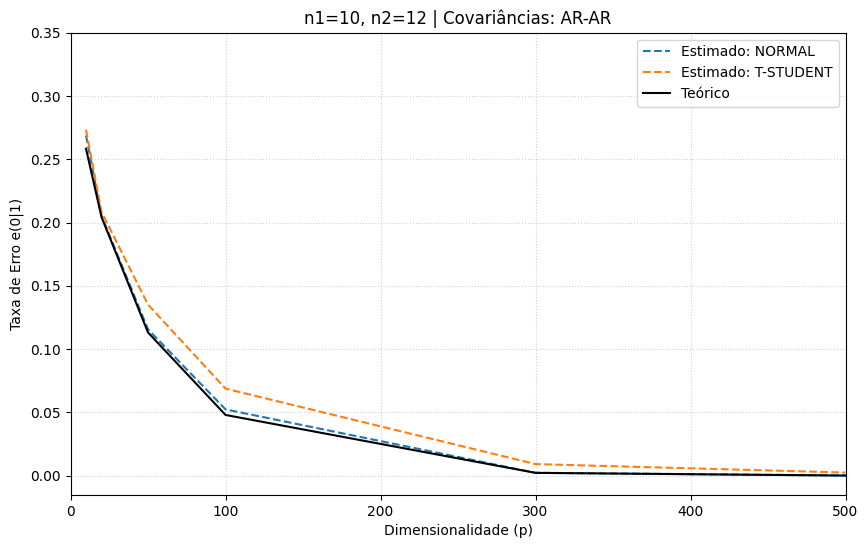

In [2]:
# Parâmetros da simulação, conforme o artigo
p_values = [10, 20, 50, 100, 300, 500]
n_configs = [{'n1': 5, 'n2': 7}, {'n1': 10, 'n2': 12}]
dist_configs = ['normal', 't-student']
cov_case_configs = ['AR-AR']#'AR-UN',
num_runs = 50  # O artigo usa 1000, mas 50 é mais rápido para testes,

for n_config in n_configs:
    for cov_case in cov_case_configs:

        base_title = f"n1={n_config['n1']}, n2={n_config['n2']} | Covariâncias: {cov_case}"
        print(f"--- Iniciando Simulação: {base_title} ---")

        results_e10 = {}
        results_e01 = {}
        theoretical_e10 = {}
        theoretical_e01 = {}

        # Calcula os erros teóricos uma vez para cada 'p'
        for p in p_values:
            params = {**n_config, 'p': p, 'cov_case': cov_case}
            if cov_case == 'AR-AR':
                sigma1 = create_ar1_covariance(p, 0.3)
                sigma2 = create_ar1_covariance(p, 0.7)
            else: # 'AR-UN'
                sigma1 = create_ar1_covariance(p, 0.5)
                sigma2 = create_unstructured_covariance(p)
            mu1, mu2 = generate_mean_vectors(p)
            e10, e01 = calculate_theoretical_errors(mu1=mu1, mu2=mu2, Sigma1=sigma1, Sigma2=sigma2, n1=n_config['n1'], n2=n_config['n2'])
            theoretical_e10[p] = e10
            theoretical_e01[p] = e01
        
        # Executa as simulações de Monte Carlo para cada distribuição
        for dist in dist_configs:
            errors_by_p_e10, errors_by_p_e01 = {}, {}
            label = f"Estimado: {dist.upper()}"
            print(f"  Avaliando para {label}...")
            
            for p in p_values:
                current_errors_e10 = []
                current_errors_e01 = []
                for i in range(num_runs):
                    params = {**n_config, 'p': p, 'dist': dist, 'cov_case': cov_case}
                    e10, e01 = run_simulation_iteration(params)
                    current_errors_e10.append(e10)
                    current_errors_e01.append(e01)
                
                errors_by_p_e10[p] = np.mean(current_errors_e10)
                errors_by_p_e01[p] = np.mean(current_errors_e01)
                print(f"    p = {p:<4} | e(1|0)={np.mean(current_errors_e10):.4f}, e(0|1)={np.mean(current_errors_e01):.4f}")
            
            results_e10[label] = errors_by_p_e10
            results_e01[label] = errors_by_p_e01
        
        # Plota os resultados para a configuração atual
        plot_results(results_e10,  base_title, "Taxa de Erro e(1|0)", theoretical_e10)
        plot_results(results_e01,  base_title, "Taxa de Erro e(0|1)", theoretical_e01)

## Seção 2: Geração dos QQ-Plots

  Gerando dados para QQ-Plot: p=100, dist=normal, cov=AR-AR...
  Gerando dados para QQ-Plot: p=500, dist=normal, cov=AR-AR...
  Gerando dados para QQ-Plot: p=1000, dist=normal, cov=AR-AR...
  Gerando dados para QQ-Plot: p=100, dist=t-student, cov=AR-AR...
  Gerando dados para QQ-Plot: p=500, dist=t-student, cov=AR-AR...
  Gerando dados para QQ-Plot: p=1000, dist=t-student, cov=AR-AR...


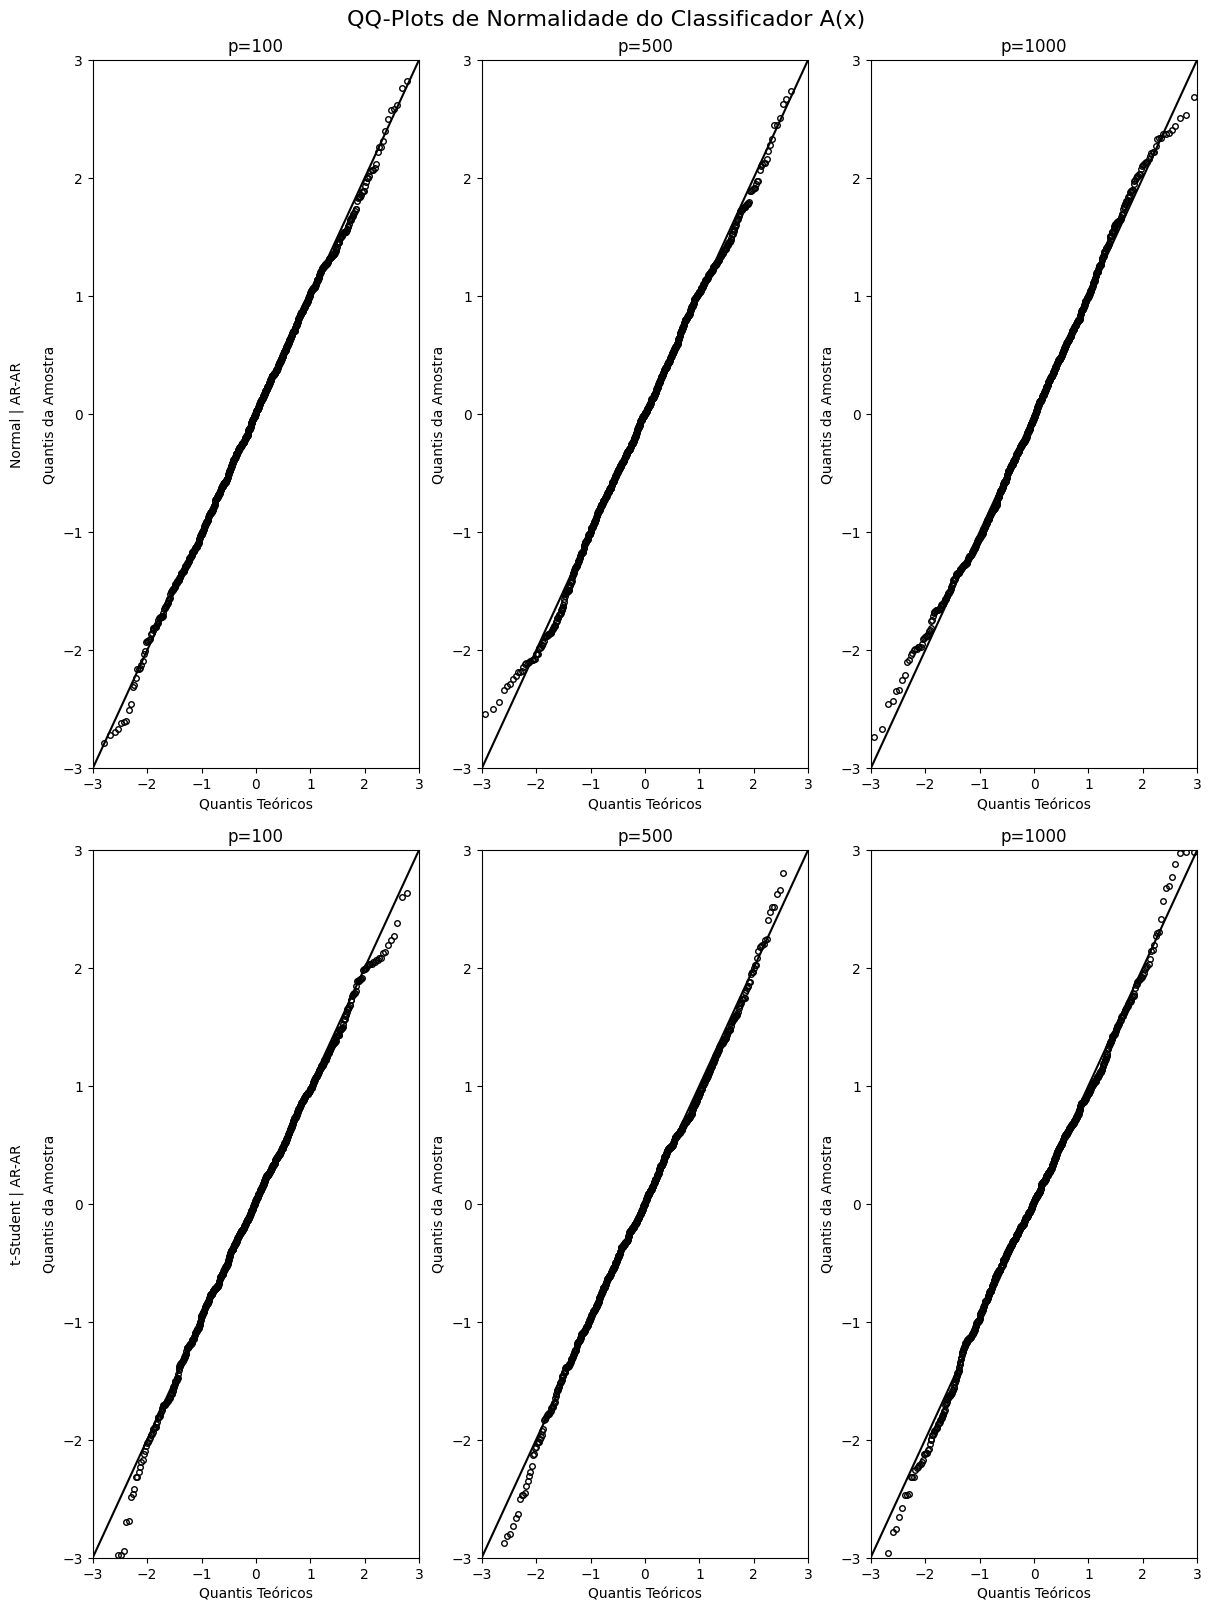

In [3]:
qq_p_values = [100, 500, 1000]
qq_n_config = {'n1': 5, 'n2': 7}

# Ordem conforme a legenda da Figura 1 do artigo
qq_configs = [
    #{'dist': 'normal', 'cov_case': 'AR-UN', 'label': 'Normal | AR-UN'},
    {'dist': 'normal', 'cov_case': 'AR-AR', 'label': 'Normal | AR-AR'},
    #{'dist': 't-student', 'cov_case': 'AR-UN', 'label': 't-student-Student | AR-UN'},
    {'dist': 't-student', 'cov_case': 'AR-AR', 'label': 't-Student | AR-AR'},
]
num_qq_samples = 1000 # Número de pontos a serem gerados para o gráfico

fig, axes = plt.subplots(len(qq_configs), len(qq_p_values), figsize=(12, 16), constrained_layout=True)
fig.suptitle("QQ-Plots de Normalidade do Classificador A(x)", fontsize=16)

for row, config in enumerate(qq_configs):
    for col, p in enumerate(qq_p_values):
        print(f"  Gerando dados para QQ-Plot: p={p}, dist={config['dist']}, cov={config['cov_case']}...")
        params = {**qq_n_config, 'p': p, 'dist': config['dist'], 'cov_case': config['cov_case']}

        # Gerar dados de treino e teste
        mu1 = np.zeros(p)
        mu2 = np.ones(p)
        mu2[:p // 3] = 0

        if params['cov_case'] == 'AR-AR':
            cov1 = create_ar1_covariance(p, 0.3)
            cov2 = create_ar1_covariance(p, 0.7)
        else: # 'AR-UN'
            cov1 = create_ar1_covariance(p, 0.5)
            cov2 = create_unstructured_covariance(p)

        X1_train = generate_data(params['n1'], mu1, cov1, params['dist'])
        X2_train = generate_data(params['n2'], mu2, cov2, params['dist'])
        
        # Geramos os scores para x vindo da população 1
        X_test = generate_data(num_qq_samples, mu1, cov1, params['dist'])
        
        # Calcula os scores do classificador A(x) = A₁(x) - A₂(x)
        score_diffs = []
        for x_test in X_test:
            # Chama a função para obter os scores [A₁(x), A₂(x)]
            scores = u_classifier_multisample(x_test, [X1_train, X2_train], return_scores=True)
            score_diffs.append(scores[0] - scores[1])
        
        classifier_scores = np.array(score_diffs)

        # Padroniza os scores para uma melhor visualização
        if np.std(classifier_scores) > 1e-9: # Evita divisão por zero
            standardized_scores = (classifier_scores - np.mean(classifier_scores)) / np.std(classifier_scores)
        else:
            standardized_scores = classifier_scores - np.mean(classifier_scores)
        
        # Plotando no eixo correto
        ax = axes[row, col]
        plot_qq(standardized_scores, ax, f"p={p}")
        
        # Adiciona rótulo da linha à esquerda
        if col == 0:
            ax.set_ylabel(f"{config['label']}\n\nQuantis da Amostra")

plt.show()